# Separating Low and High Noise Regimes in GPs

Learning a dynamics model without separating the different operational modes has a detrimental impact on performance. We therefore seek a model that can identify and learn a separation between the different operational regimes (modes) and as a result learn a better representation of the true underlying dynamics.

In this work we seek to extend Gaussian process dynamics models to a bi-modal setting, where the noise in one mode is much larger than the other.


## Problem Statement
In regression we wish to estimate a continuous target variable $\mathbf{Y}$ from an observed variate $\mathbf{X}$. The target $\mathbf{Y}$ and observered $\mathbf{X}$ variates are thus related through the mapping,

$$f : \mathbf{x} \rightarrow \mathbf{y},$$

where $f$ indicates the mapping. In this work we assume that the mapping $f$ consists of two regimes $\{f_1, f_2\}$,

\begin{equation}
    f = \begin{cases}
      f_1 = g + \epsilon	_1,\\
      f_2 = g + \epsilon	_2 \\
    \end{cases}
\end{equation}

where $\epsilon_i \sim \mathcal{N}(0, \Sigma_{i})$ and $\epsilon_1 \gg \epsilon_2$ i.e. the noise in one mode is much larger compared to the other.

Our proposed model assumes that a latent function $g$ generates $N$ pairs of observations with Gaussian noise added from one of the two modes, resulting in the data set $\mathcal{D} = \{(\mathbf{x}_n, \mathbf{y}_n)\}_{n=1}^N$. The assignment of the $n^{\text{th}}$ data point is specified by the variable $\alpha_n \in \{0, 1 \}$. We denote all of the $N$ inputs $\mathbf{X} = [\mathbf{x}_1, ..., \mathbf{x}_N]$, all of the targets $\mathbf{Y} = [\mathbf{y}_1, ..., \mathbf{y}_N]$ and all of the assignments $\pmb{\alpha} = \{ \alpha_1, ..., \alpha_N \}$. The value of the latent function $g$ associated with the $n^{\text{th}}$ input is denoted as $\mathbf{g}_n = g(\mathbf{x}_n)$ and collected into $\mathbf{G} = \{ \mathbf{g}_1,...,\mathbf{g}_N \}$ for all data points. The likelihood of our model takes the form,

\begin{equation}
	p(\mathbf{Y} | g, \pmb{\alpha}) = {\displaystyle \prod_{n=1}^{N}} \mathcal{N}	(\mathbf{y}_n|g, \epsilon_1)^{\alpha_n} \mathcal{N}	(\mathbf{y}_n|g, \epsilon_2)^{1 - \alpha_n},
\end{equation}

and we place a GP prior on the latent function $g$,

\begin{equation}
	p(g | \mathbf{X}) = \mathcal{N}(g|\mathbf{0}, k_g({\mathbf{X},\mathbf{X}})),
\end{equation}

where $k_g(\cdot, \cdot)$ represents the squared exponential kernel with automatic relevance determination. For now, we assume that the assignments $\pmb{\alpha}$ are known during training and at prediction.

In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

Lets create a function to represent our underlying mapping $g$.

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

Lets now generate a set of $N$ observations, assuming that the Bernoulli indicator variable $\alpha$ is known.

In [3]:
N = 1000 # number of training observations

# generate input observations X
# X = rnd.rand(N, 1) * 2 - 1 # X values
X = np.linspace(-1.0, 1.0, N)[:, None]

# generate target observations Y
Y = np.zeros([N, 1])
Y = func(X) + 0.05 * rnd.randn(1000,1)
Y[-200:] += 0.3 * rnd.randn(200,1) # add noise to subset of target observations Y
Y[:200] += 0.3 * rnd.randn(200,1) # add noise to subset of target observations Y

# Bernoulli indicator variable, 0 = low noise, 1 = high noise
a = np.zeros([N, 1])
a[-200:] = 1
a[:200] = 1

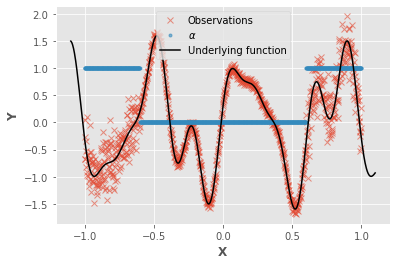

In [4]:
plt.plot(X, Y, 'x', alpha=0.6, label="Observations")
plt.plot(X, a, '.', alpha=0.6, label="$\\alpha$")
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k', label="Underlying function")
plt.xlabel("$\mathbf{X}$")
plt.ylabel("$\mathbf{Y}$")
plt.legend()
plt.savefig("img/dataset.pdf", transparent=True)

In [5]:
import gpflow
from gpflow.models.model import Model
from gpflow.params.dataholders import Minibatch, DataHolder
from gpflow.params import Parameter, ParamList
from gpflow.training import AdamOptimizer, ScipyOptimizer
from gpflow.decors import params_as_tensors, autoflow
from gpflow.likelihoods import Likelihood

float_type = gpflow.settings.float_type

W0821 16:11:39.743212 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0821 16:11:39.744485 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0821 16:11:39.868983 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:169: The name tf.train.AdadeltaOptimizer is deprecated. Please use tf.compat.v1.train.AdadeltaOptimizer instead.

W0821 16:11:39.869711 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:156: The name tf.train.Optimizer is deprecated. Please use 

Once we have a GPflow model we specify its objective function, parameters and dataset. This extra layer of abstraction makes interacting with the model, such as optimizing or performing inference, much easier.

We continue by creating a BMSMGP class that inherits from GPflow's model class. We now need to do the following things:

1. **Store the input X, target Y and assignment $\alpha$ matrices as DataHolders**.
2. **Define our model's parameters using GPflow's Parameter and ParamList objects**. 
    * Our parameters consist of two sets of kernel parameters (one for each mode).
    * Two noise variances (one for each mode).
    * Mean and variances for each inducing point (as we assume normal variational dists for each inducing point).
3. **Define the objective function**. In the \_build_likelood function we need to specify our model's objective function. When we optimize the model the negative of this function will be minimized.
    * Our objective function is the lower bound for the log joint $\text{log}\ p(\mathbf{Y}, \pmb{\alpha} | \mathbf{X})$,
\begin{align}
\mathcal{L} &= \sum_{n=1}^N \mathbb{E}_{q(\mathbf{H}, \mathbf{G}, \mathbf{U})}\bigg[\text{log}\ p(\mathbf{y}_n | \mathbf{g}_n, \pmb{\alpha}_n) \bigg] \\
&\ + \sum_{n=1}^N \mathbb{E}_{q(\mathbf{H}, \mathbf{G}, \mathbf{U})}\bigg[\text{log}\ p(\pmb{\alpha}_n | \mathbf{h}_n) \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_h) || p(\mathbf{U}_h)) \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g))
\end{align}

However, for now we assume $\alpha$ is given so our lower bound is,

\begin{align}
\mathcal{L} &= \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ p(\mathbf{y}_n | \mathbf{g}_n, \pmb{\alpha}_n) \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g)) \\
&= \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_1)^{\alpha_n} \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_2)^{1 - \alpha_n} \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g)) \\
&= \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_1)^{\alpha_n} \bigg]
+ \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_2)^{1 - \alpha_n} \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g)) \\
&= \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_1)^{\alpha_n} \bigg]
+ \mathbb{E}_{q(\mathbf{U}_g)} \sum_{n=1}^N \mathbb{E}_{q(\mathbf{G} | \mathbf{U}_g)}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_n, \epsilon_2)^{1 - \alpha_n} \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g))
\end{align}

In the below code I assume that there are two separate GPs so the bound would take the form,

\begin{align}
\mathcal{L} 
&= \mathbb{E}_{q(\mathbf{U}_{g_1})} \Bigg[ \sum_{n=1}^N \mathbb{E}_{p(\mathbf{G}_1 | \mathbf{U}_{g_1})}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_{1,n}, \epsilon_1)^{\alpha_n} \bigg] \Bigg] \\
&+ \mathbb{E}_{q(\mathbf{U}_{g_2})} \Bigg[ \sum_{n=1}^N \mathbb{E}_{p(\mathbf{G}_2 | \mathbf{U}_{g_2})}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_{2,n}, \epsilon_2)^{1 - \alpha_n} \bigg] \Bigg] \\
&\ - \text{KL}(q(\mathbf{U}_{g_1}) || p(\mathbf{U}_{g_1})) \\
&\ - \text{KL}(q(\mathbf{U}_{g_2}) || p(\mathbf{U}_{g_2})) .
\end{align}

This is just equivalent to two sparse variational GPs (one for each mode) each trained with the observations assocaited to that mode. Our objective function (variational bound) is thus the sum of the variational bounds of each GP.

In [6]:
from gpflow.models import SVGP

class BMGP(Model):
    def __init__(self, X, Y, a):
        Model.__init__(self)
        self.X = DataHolder(X)
        self.Y = DataHolder(Y)
        self.a = DataHolder(a)

        # initialise a SVGP for each mode
        self.m_low = self._init_svgp(X[a==0], Y[a==0])
        self.m_high = self._init_svgp(X[a==1], Y[a==1])
   
    def _init_svgp(self, X, Y, feature=None, minibatch_size=100):
        # TODO: Extend to multivariate case
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("X array is not of the right shape")
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("Y array is not of the right shape")
            
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        
        if feature is None:
            M = 50
            idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
            feature = X[idx, ...].reshape(-1, 1)
            
        svgp = SVGP(X, Y, kern=kern, likelihood=gpflow.likelihoods.Gaussian(), Z=feature, minibatch_size=minibatch_size)

        # make inducing points not trainable as they are now represented as variational normal dists
        svgp.feature.trainable = False
        return svgp
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        return self.m_low._build_likelihood() + self.m_high._build_likelihood()

    @params_as_tensors
    def _predict_low(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_low.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def _predict_high(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_high.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def predict_y(self, Xnew, a, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        mu = np.empty(Xnew.shape)
        var = np.empty(Xnew.shape)
        mu[a[:, 0]==0], var[a[:, 0]==0] = self._predict_low(Xnew[a==0])
        mu[a[:, 0]==1], var[a[:, 0]==1] = self._predict_high(Xnew[a==1])
        return mu, var
    
#     @params_as_tensors
#     def predict_y(self, Xnew, a, full_cov=False, full_output_cov=False):
#         # TODO: write in tensorflow
#         mu = np.empty(Xnew.shape)
#         var = np.empty(Xnew.shape)
#         mu[a[:, 0]==0], var[a[:, 0]==0] = self.m_low.predict_y(Xnew[a==0].reshape(-1, 1))
#         mu[a[:, 0]==1], var[a[:, 0]==1] = self.m_high.predict_y(Xnew[a==1].reshape(-1, 1))
#         return mu, var

In [7]:
m_f = BMGP(X, Y, a)
m_f.as_pandas_table()

W0821 16:11:43.071541 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 16:11:43.098685 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 16:11:43.100247 4584084928 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/params/parameter.py:394: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0821 16:11:43.117207 4584084928 deprecation.py:323] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

,class,prior,transform,trainable,shape,fixed_shape,value
BMGP/m_high/feature/Z,Parameter,None,(none),False,"(50, 1)",True,"[[-0.7997997997997999], [0.6196196196196195], ..."
BMGP/m_high/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
BMGP/m_high/kern/variance,Parameter,None,+ve,True,(),True,1.0
BMGP/m_high/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
BMGP/m_high/q_mu,Parameter,None,(none),True,"(50, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
BMGP/m_high/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 50, 50)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
BMGP/m_low/feature/Z,Parameter,None,(none),False,"(50, 1)",True,"[[-0.21921921921921927], [-0.3313313313313313]..."
BMGP/m_low/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
BMGP/m_low/kern/variance,Parameter,None,+ve,True,(),True,1.0
BMGP/m_low/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


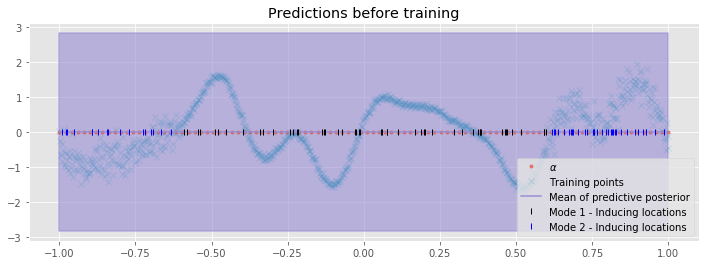

In [8]:
def plot(a_flag=0, title=""):
    plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations
    if a_flag == 0:
        pA = np.zeros([100, 1])
    elif a_flag == 1:
        pA = np.ones([100, 1])
    elif a_flag == 2:
        pA = np.zeros([100, 1])
        pA[:20] = 1
        pA[-20:] = 1
    else:
        pA = np.zeros([100, 1])
    plt.plot(pX, pA, '.', alpha=0.6, label="$\\alpha$")
    pY, pYv = m_f.predict_y(pX, pA) # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
#     plt.fill_between(pX[:, 0], (pY-2*pYv**0.5), (pY+2*pYv**0.5), color=col, alpha=0.6, lw=1.5)
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.6, lw=1.5)
    plt.plot(m_f.m_low.feature.Z.value, np.zeros(m_f.m_low.feature.Z.value.shape), 'k|', mew=1, label='Mode 1 - Inducing locations')
    plt.plot(m_f.m_high.feature.Z.value, np.zeros(m_f.m_high.feature.Z.value.shape), 'b|', mew=1, label='Mode 2 - Inducing locations')
    plt.legend(loc='lower right')
    plt.title(title)

plot(a_flag=0, title="Predictions before training")

In [11]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [12]:
def run_adam(model, iterations):
    """
    Utility function running the Adam Optimiser interleaved with a `Logger` action.
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

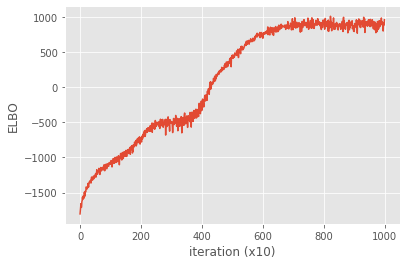

In [13]:
logger = run_adam(m_f, gpflow.test_util.notebook_niter(10000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration (x10)')
plt.ylabel('ELBO');

Lets now visualise our trained model by calling our models predict method and providing some test inputs $\mathbf{X}_*$ and their corresponing assignment indicator variables $\pmb{\alpha}$.

We will first assume that all test inputs belong to the high noise mode where $\alpha=1$.

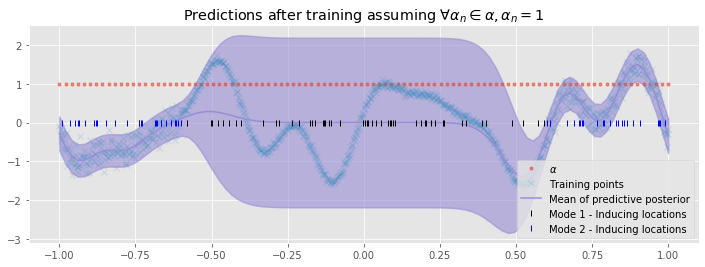

In [14]:
plot(a_flag=1, title="Predictions after training assuming $ \\forall \\alpha_n \in \\alpha, \\alpha_n = 1$")

It is clear that the model has learnt the correct noise variance for the high noise mode and that prediciting at locations of the low noise mode just returns the initial zero mean prior.

Now lets assume that all test inputs belong to the low noise mode where $\alpha=0$.

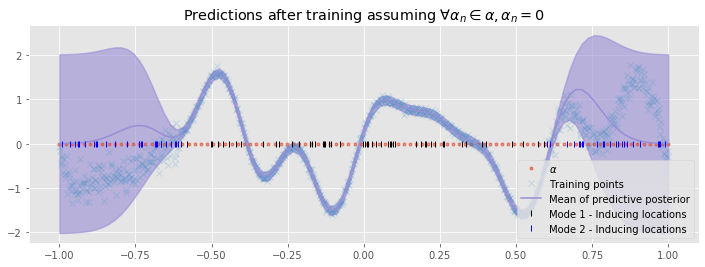

In [15]:
plot(a_flag=0, title="Predictions after training assuming $ \\forall \\alpha_n \in \\alpha, \\alpha_n = 0$")

It is clear that the model has learnt the correct noise variance for the low noise mode and that prediciting at locations of the high noise mode just returns the initial zero mean prior.

Now lets provide our model with the correct assignments $\alpha$.

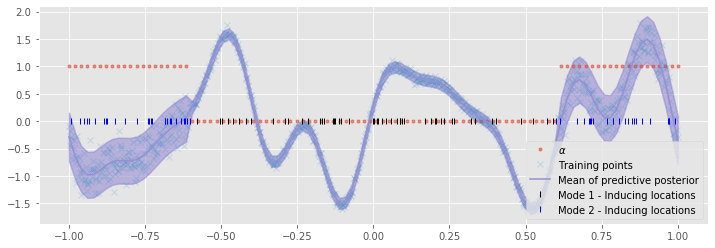

In [16]:
# plot(a_flag=2, title="Predictions after training with correct $\\alpha$")
plot(a_flag=2, title="")
plt.savefig("img/bimode.pdf", transparent=True)

Lets make a pretty plot.

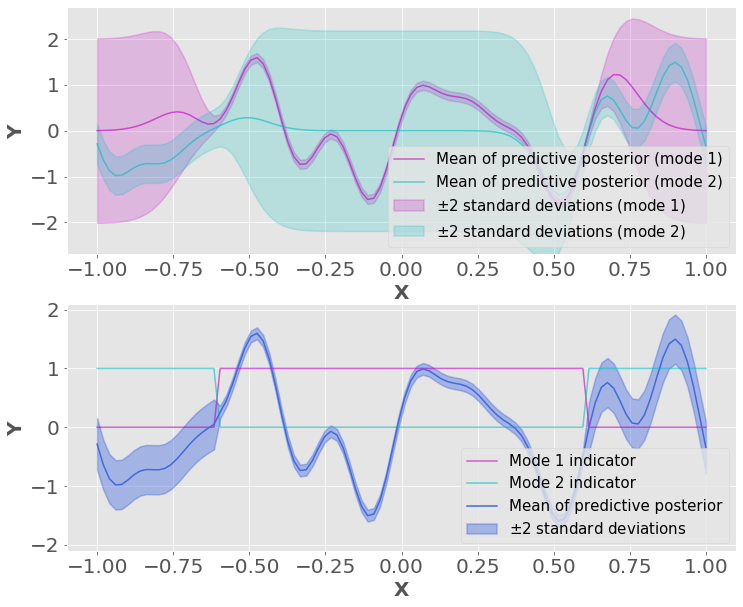

In [17]:
fig = plt.figure(figsize=(12, 10))
fig.add_subplot(211)
# plt.figure(figsize=(12, 4))

pX = np.linspace(-1, 1, 100)[:, None] # Test locations
pA = np.zeros([100, 1])
pA[:20] = 1
pA[-20:] = 1
#     plt.plot(pX, pA, '.', alpha=0.6, label="$\\alpha$")
pY_low, pYv_low = m_f._predict_low(pX) # Predict Y values at test locations
pY_high, pYv_high = m_f._predict_high(pX) # Predict Y values at test locations
#     plt.plot(X[a==0], Y[a==0], 'x', color='r', label='Mode 1 - Training points', alpha=0.2)
#     plt.plot(X[a==1], Y[a==1], 'x', color='b', label='Mode 2 - Training points', alpha=0.2)
line, = plt.plot(pX, pY_low, color='m', alpha=0.6, lw=1.5, label='Mean of predictive posterior (mode 1)')
line, = plt.plot(pX, pY_high, color='c', alpha=0.6, lw=1.5, label='Mean of predictive posterior (mode 2)')
col = line.get_color()
#     plt.fill_between(pX[:, 0], (pY-2*pYv**0.5), (pY+2*pYv**0.5), color=col, alpha=0.6, lw=1.5)
plt.fill_between(pX[:, 0], (pY_low-2*pYv_low**0.5)[:, 0], (pY_low+2*pYv_low**0.5)[:, 0], color='m', alpha=0.2, lw=1.5, label='$\pm 2$ standard deviations (mode 1)')
plt.fill_between(pX[:, 0], (pY_high-2*pYv_high**0.5)[:, 0], (pY_high+2*pYv_high**0.5)[:, 0], color='c', alpha=0.2, lw=1.5, label='$\pm 2$ standard deviations (mode 2)')
#     plt.plot(m.m_low.feature.Z.value, np.zeros(m.m_low.feature.Z.value.shape), 'k|', mew=1, label='Mode 1 - Inducing locations')
#     plt.plot(m.m_high.feature.Z.value, np.zeros(m.m_high.feature.Z.value.shape), 'b|', mew=1, label='Mode 2 - Inducing locations')
plt.legend(loc='lower right', fontsize=15)
plt.xlabel("$\mathbf{X}$", fontsize=20)
plt.ylabel("$\mathbf{Y}$", fontsize=20)
plt.ylim(-2.7, 2.7)
plt.tick_params(labelsize=20)
plt.title("")

fig.add_subplot(212)
# plt.figure(figsize=(12, 4))
pX = np.linspace(-1, 1, 100)[:, None] # Test locations
pA = np.zeros([100, 1])
pA[:20] = 1
pA[-20:] = 1
pA1 = np.zeros(pA.shape)
pA1[pA==0] = 1
plt.plot(pX, pA1, '-', color='m', alpha=0.6, label="Mode 1 indicator")
plt.plot(pX, pA, '-', color='c', alpha=0.6, label="Mode 2 indicator")
pY, pYv = m_f.predict_y(pX, pA) # Predict Y values at test locations
line, = plt.plot(pX, pY, color='royalblue', lw=1.5, label='Mean of predictive posterior')
col = line.get_color()
# plt.plot(X, Y, 'x', color=col, label='Training points', alpha=0.4)
#     plt.fill_between(pX[:, 0], (pY-2*pYv**0.5), (pY+2*pYv**0.5), color=col, alpha=0.6, lw=1.5)
plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.4, lw=1.5, label='$\pm 2$ standard deviations')
# plt.plot(m.m_low.feature.Z.value, np.zeros(m.m_low.feature.Z.value.shape), 'k|', mew=1, label='Mode 1 - Inducing locations')
# plt.plot(m.m_high.feature.Z.value, np.zeros(m.m_high.feature.Z.value.shape), 'b|', mew=1, label='Mode 2 - Inducing locations')
plt.legend(loc='lower right', fontsize=15)
plt.xlabel("$\mathbf{X}$", fontsize=20)
plt.ylabel("$\mathbf{Y}$", fontsize=20)
plt.tick_params(labelsize=20)
plt.ylim(-2.1, 2.1)
plt.title("")
plt.savefig("img/combined.pdf", transparent=True)

We can see that the model is capable of modelling the variance of each mode.

Lets print the learnt parameters.

In [18]:
m_f.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMGP/m_high/feature/Z,Parameter,None,(none),False,"(50, 1)",True,"[[-0.6656656656656657], [0.98998998998999], [-..."
BMGP/m_high/kern/lengthscales,Parameter,None,+ve,True,(),True,0.09408194829553118
BMGP/m_high/kern/variance,Parameter,None,+ve,True,(),True,1.1564057211146717
BMGP/m_high/likelihood/variance,Parameter,None,+ve,True,(),True,0.04246858505728031
BMGP/m_high/q_mu,Parameter,None,(none),True,"(50, 1)",True,"[[-0.12422331491685415], [-0.08208421342473413..."
BMGP/m_high/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 50, 50)",True,"[[[0.03329513166019756, 0.0, 0.0, 0.0, 0.0, 0...."
BMGP/m_low/feature/Z,Parameter,None,(none),False,"(50, 1)",True,"[[-0.4974974974974975], [0.041041041041041115]..."
BMGP/m_low/kern/lengthscales,Parameter,None,+ve,True,(),True,0.10831512006881959
BMGP/m_low/kern/variance,Parameter,None,+ve,True,(),True,1.0126002483586252
BMGP/m_low/likelihood/variance,Parameter,None,+ve,True,(),True,0.002421584446616096


Now that we have shown that our model is capable of modelling our data lets move onto the next step of inferring the assignments $\pmb{\alpha}$ from the training data. This requires computing the following,

\begin{equation}
\sum_{n=1}^N \mathbb{E}_{q(\mathbf{H}, \mathbf{G}, \mathbf{U})}\bigg[\text{log}\ p(\pmb{\alpha}_n | \mathbf{h}_n) \bigg] - \text{KL}(q(\mathbf{U}_h) || p(\mathbf{U}_h)),
\end{equation}
and adding it to our lower bound, to get,
\begin{align}
\mathcal{L} &= \sum_{n=1}^N \mathbb{E}_{q(\mathbf{H}, \mathbf{G}, \mathbf{U})}\bigg[\text{log}\ p(\mathbf{y}_n | \mathbf{g}_n, \pmb{\alpha}_n) \bigg] \\
&\ + \sum_{n=1}^N \mathbb{E}_{q(\mathbf{H}, \mathbf{G}, \mathbf{U})}\bigg[\text{log}\ p(\pmb{\alpha}_n | \mathbf{h}_n) \bigg] \\
&\ - \text{KL}(q(\mathbf{U}_h) || p(\mathbf{U}_h)) \\
&\ - \text{KL}(q(\mathbf{U}_g) || p(\mathbf{U}_g)) \\
&= \mathbb{E}_{q(\mathbf{U}_{g_1})} \Bigg[ \sum_{n=1}^N \mathbb{E}_{p(\mathbf{G}_1 | \mathbf{U}_{g_1})}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_{1,n}, \epsilon_1)^{\alpha_n} \bigg] \Bigg] \\
&+ \mathbb{E}_{q(\mathbf{U}_{g_2})} \Bigg[ \sum_{n=1}^N \mathbb{E}_{p(\mathbf{G}_2 | \mathbf{U}_{g_2})}\bigg[\text{log}\ \mathcal{N}(\mathbf{y}_n | \mathbf{g}_{2,n}, \epsilon_2)^{1 - \alpha_n} \bigg] \Bigg] \\
&\ - \text{KL}(q(\mathbf{U}_{g_1}) || p(\mathbf{U}_{g_1})) \\
&\ - \text{KL}(q(\mathbf{U}_{g_2}) || p(\mathbf{U}_{g_2})) \\
&\ + \mathbb{E}_{q(\mathbf{U}_{h})} \Bigg[ \sum_{n=1}^N \mathbb{E}_{p(\mathbf{H} | \mathbf{U}_{h})}\bigg[\text{log}\ p(\pmb{\alpha}_n | \mathbf{h}_{n}) \bigg] \Bigg] \\
&\ - \text{KL}(q(\mathbf{U}_{h}) || p(\mathbf{U}_{h})) .
\end{align}

In [19]:
from gpflow.models import SVGP
from gpflow.params import Parameter
from gpflow.transforms import Logistic

class SMGP(Model):
    def __init__(self, X, Y, a):
        Model.__init__(self)
        self.X = DataHolder(X)
        self.Y = DataHolder(Y)
        self.a = DataHolder(a)
        
        # initialise GP for separation manifold
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        M = 50
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        feature = X[idx, ...].reshape(-1, 1)
        minibatch_size = 100
        self.m_h = SVGP(X, a, kern=kern, likelihood=gpflow.likelihoods.Bernoulli(), Z=feature, minibatch_size=minibatch_size)
        self.m_h.feature.trainable = False
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        return self.m_h._build_likelihood()

    @params_as_tensors
    def predict_y(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_h.predict_y(Xnew)

In [20]:
with gpflow.defer_build():
    m_h = SMGP(X, Y, a)
    m_h.compile()

Kmm
Tensor("SMGP-c899ca63-32/m_h/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("SMGP-c899ca63-32/m_h/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)
Kmm
Tensor("SMGP-c899ca63-32/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("SMGP-c899ca63-32/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)


Kmm
Tensor("autoflow/SVGP/predict_y_12/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("autoflow/SVGP/predict_y_12/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)


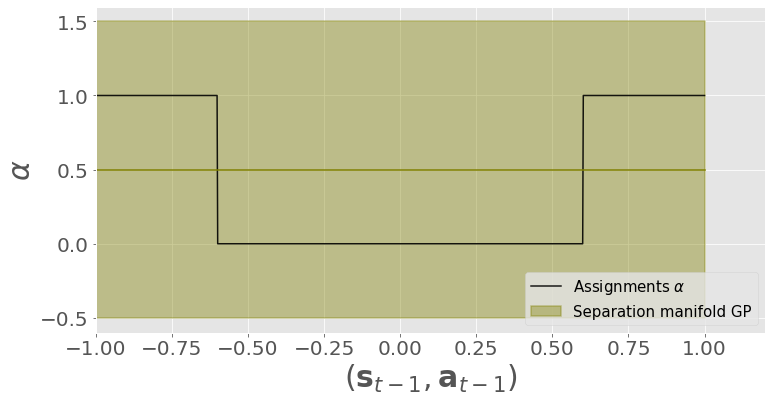

In [21]:
def plot_h(title=""):
    plt.figure(figsize=(12, 6))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations
#     plt.plot(pX, pA, '.', alpha=0.6, label="$\\alpha$")
    pA, pAv = m_h.predict_y(pX) # Predict Y values at test locations
    plt.plot(X, a, '-', color='k', label='Assignments $\\alpha$', alpha=0.9)
    line, = plt.plot(pX, pA, color='olive', lw=1.5)
#     plt.fill_between(pX[:, 0], (pY-2*pYv**0.5), (pY+2*pYv**0.5), color=col, alpha=0.6, lw=1.5)
    plt.fill_between(pX[:, 0], (pA-2*pAv**0.5)[:, 0], (pA+2*pAv**0.5)[:, 0], color='olive', alpha=0.4, lw=1.5, label='Separation manifold GP')
#     plt.plot(m_h.m_h.feature.Z.value, np.zeros(m_h.m_h.feature.Z.value.shape), 'k|', mew=1, label='Inducing locations')
    plt.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\\alpha$', fontsize=30)
    plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    plt.title(title)

plot_h("")

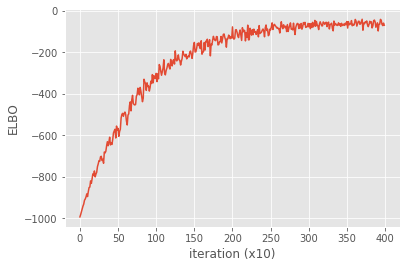

In [22]:
logger = run_adam(m_h, gpflow.test_util.notebook_niter(4000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration (x10)')
plt.ylabel('ELBO');

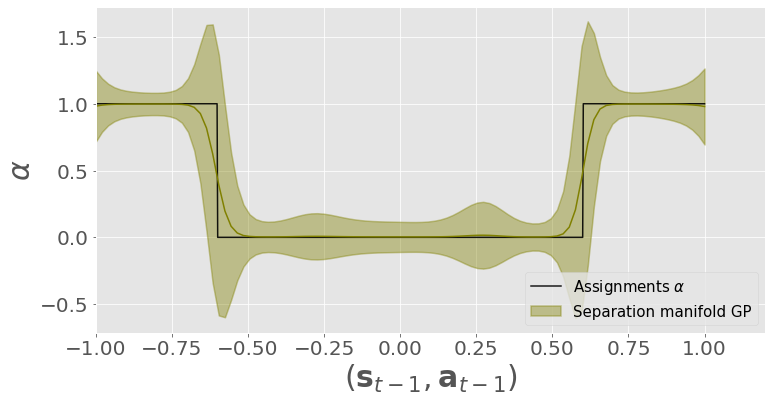

In [23]:
# plot_h(title="Learnt separation manifold $h$")
plot_h('')
plt.savefig('img/separation.pdf', transparent=True, bbox_inches='tight')

# BMSMGP

In [29]:
from gpflow.models import SVGP

class BMSMGP(Model):
    def __init__(self, X, Y, a):
        Model.__init__(self)
        self.X = DataHolder(X)
        self.Y = DataHolder(Y)
        self.a = DataHolder(a)
        
        # initialise GP for separation manifold
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        M = 50
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        feature = X[idx, ...].reshape(-1, 1)
        minibatch_size = 100
        
        with gpflow.defer_build():
            self.m_h = SVGP(X, a, kern=kern, likelihood=gpflow.likelihoods.Bernoulli(), Z=feature, minibatch_size=minibatch_size)
            self.m_h.feature.trainable = False
            self.m_h.compile()

        # initialise a SVGP for each mode
        self.m_low = self._init_svgp(X[a==0], Y[a==0])
        self.m_high = self._init_svgp(X[a==1], Y[a==1])
   
    def _init_svgp(self, X, Y, feature=None, minibatch_size=100):
        # TODO: Extend to multivariate case
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("X array is not of the right shape")
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("Y array is not of the right shape")
            
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        
        if feature is None:
            M = 50
            idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
            feature = X[idx, ...].reshape(-1, 1)
            
        svgp = SVGP(X, Y, kern=kern, likelihood=gpflow.likelihoods.Gaussian(), Z=feature, minibatch_size=minibatch_size)

        # make inducing points not trainable as they are now represented as variational normal dists
        svgp.feature.trainable = False
        return svgp
    
    @params_as_tensors
    def _optimise_h(self, iterations, plot=True):
        print("Starting optimisation of separation manifold GP....")
        logger = self.run_adam(self.m_h, iterations)
        if plot is True:
            self._plot_loss(logger)
        print("Finished with optimisation of separation manifold GP")
      
    @params_as_tensors
    def optimise(self, iterations_h=4000, iterations_f=10000, plot=True):
        self._optimise_h(iterations_h)
        self.m_h.trainable = False
        print("Starting optimisation of dynamics GPs....")
        logger = self.run_adam(self, iterations_f)
        if plot is True:
            self._plot_loss(logger)
        print("Finished with optimisation of dynamics GPs")
        
    def _plot_loss(self, logger):
        plt.plot(-np.array(logger.logf))
        plt.xlabel('iteration (x10)')
        plt.ylabel('ELBO')
        plt.show()
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        fmean, fvar = self.m_low._build_predict(self.X, full_cov=False, full_output_cov=False)
        print("f_var")
        print(fvar)
        print("fmean")
        print(fmean)
        return self.m_low._build_likelihood() + self.m_high._build_likelihood()
    
    def run_adam(self, model, iterations):
        """
        Utility function running the Adam Optimiser interleaved with a `Logger` action.
        :param interations: number of iterations
        """
        # Create an Adam Optimiser action
        adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
        # Create a Logger action
        logger = Logger(model)
        actions = [adam, logger]
        # Create optimisation loop that interleaves Adam with Logger
        loop = gpflow.actions.Loop(actions, stop=iterations)()
        # Bind current TF session to model
        model.anchor(model.enquire_session())
        return logger

    @params_as_tensors
    def _predict_low(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_low.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def _predict_high(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_high.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def predict_y(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        a_mu, a_var = self.m_h.predict_y(Xnew)
        a = a_mu
        mu = np.empty(Xnew.shape)
        var = np.empty(Xnew.shape)
#         mu[a[:, 0]<=0.5], var[a[:, 0]<=0.5] = self._predict_low(Xnew[a<=0.5])
#         mu[a[:, 0]>0.5], var[a[:, 0]>0.5] = self._predict_high(Xnew[a>0.5])
        mu = self._predict_low(Xnew)[0] * (1-a_mu) + self._predict_high(Xnew)[0] * (a_mu)
        var = self._predict_low(Xnew)[1] * (1-a_mu) + self._predict_high(Xnew)[1] * (a_mu)
        return mu, var, a_mu, a_var

In [38]:
with gpflow.defer_build():
    m = BMSMGP(X, Y, a)
    m.compile()

Kmm
Tensor("m_h_2/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("m_h_2/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)
Kmm
Tensor("BMSMGP-223a568e-139/m_high/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("BMSMGP-223a568e-139/m_high/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)
Kmm
Tensor("BMSMGP-223a568e-139/m_low/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("BMSMGP-223a568e-139/m_low/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)
Kmm
Tensor("BMSMGP-223a568e-139/conditional/add_2:0", shape=(50, 50), dtype=float64)
Tensor("BMSMGP-223a568e-139/conditional/base_conditional/Cholesky:0", shape=(50, 50), dtype=float64)
f_var
Tensor("BMSMGP-223a568e-139/conditional/base_conditional/matrix_transpose/transpose:0", dtype=float64)
fmean
Tensor("BMSMGP-223a568e-139/add:0", dtype=float64)
Kmm
Tensor("BMSMGP-223a568e-139/conditional_1/add_2:0", shape=(50, 50), dtype=float64)
Tenso

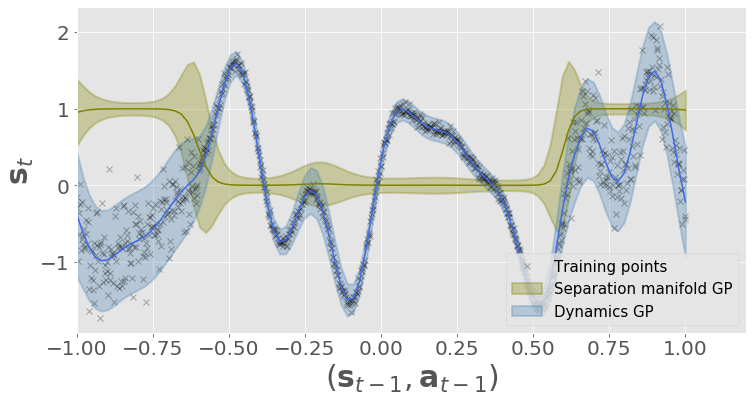

In [42]:
def plot_h(title=""):
    plt.figure(figsize=(12, 6))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations
#     plt.plot(pX, pA, '.', alpha=0.6, label="$\\alpha$")
    pY, pYv, a_mu, a_var = m.predict_y(pX) # Predict Y values at test locations
    plt.plot(X, Y, 'x', color='k', label='Training points', alpha=0.3)
    plt.plot(pX, a_mu, color='olive', lw=1.5)
    plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='olive', alpha=0.3, lw=2, label='Separation manifold GP')
    
    plt.plot(pX, pY, color='royalblue', lw=1.5)
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='steelblue', alpha=0.3, lw=2, label='Dynamics GP')
    pY_low, pYv_low = m_f._predict_low(pX) # Predict Y values at test locations
    pY_high, pYv_high = m_f._predict_high(pX) # Predict Y values at test locations
#     plt.plot(pX, pY_low, color='m', lw=1.5)
#     plt.plot(pX, pY_high, color='c', lw=1.5)
#     plt.fill_between(pX[:, 0], (pY_low-2*pYv_low**0.5)[:, 0], (pY_low+2*pYv_low**0.5)[:, 0], color='m', alpha=0.3, lw=1.5, label='Mode 1 dynamics GP')
#     plt.fill_between(pX[:, 0], (pY_high-2*pYv_high**0.5)[:, 0], (pY_high+2*pYv_high**0.5)[:, 0], color='c', alpha=0.3, lw=1.5, label='Mode 2 dynamics GP')
    
    plt.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\mathbf{s}_t$', fontsize=30)
    plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    plt.title(title)

plot_h("")

Starting optimisation of separation manifold GP....


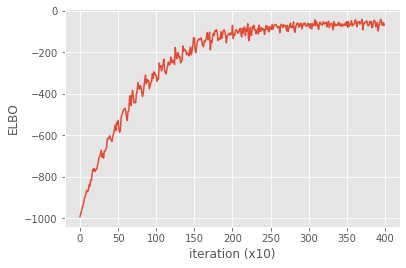

Finished with optimisation of separation manifold GP
Starting optimisation of dynamics GPs....


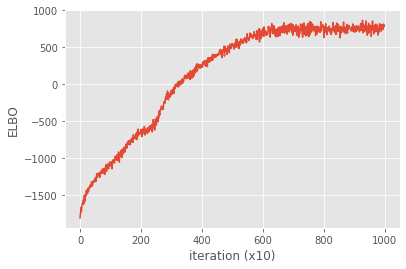

Finished with optimisation of dynamics GPs


In [40]:
m.optimise()

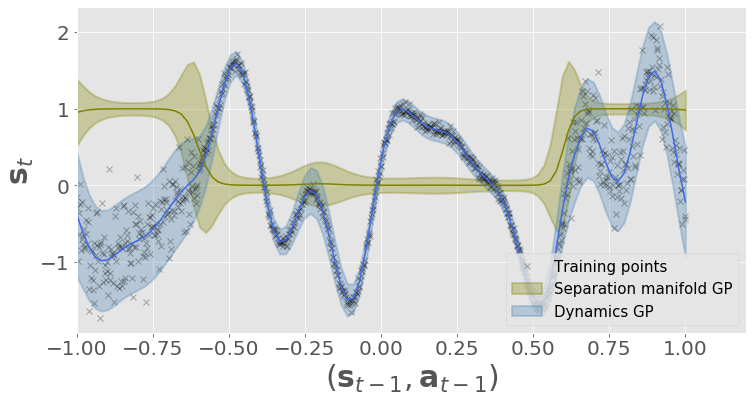

In [43]:
plot_h("")
# plt.savefig('img/bmsmgp.pdf', transparent=True, bbox_inches='tight')
plt.savefig('img/dynamicssmgp_more_noise.pdf', transparent=True, bbox_inches='tight')
# plt.savefig('img/dynamics.pdf', transparent=True, bbox_inches='tight')

## MCMC

In [5]:
from gpflow.models import Model
from gpflow import autoflow, settings


class GPModel(Model):
    """
    A base class for Gaussian process models, that is, those of the form

    .. math::
       :nowrap:

       \\begin{align}
       \\theta & \sim p(\\theta) \\\\
       f       & \sim \\mathcal{GP}(m(x), k(x, x'; \\theta)) \\\\
       f_i       & = f(x_i) \\\\
       y_i\,|\,f_i     & \sim p(y_i|f_i)
       \\end{align}

    This class mostly adds functionality to compile predictions. To use it,
    inheriting classes must define a build_predict function, which computes
    the means and variances of the latent function. This gets compiled
    similarly to build_likelihood in the Model class.

    These predictions are then pushed through the likelihood to obtain means
    and variances of held out data, self.predict_y.

    The predictions can also be used to compute the (log) density of held-out
    data via self.predict_density.

    For handling another data (Xnew, Ynew), set the new value to self.X and self.Y

    >>> m.X = Xnew
    >>> m.Y = Ynew
    """

    def __init__(self, X, Y, kern, likelihood, mean_function,
                 num_latent=None, name=None):
        super(GPModel, self).__init__(name=name)
        self.num_latent = num_latent or Y.shape[1]
        self.mean_function = mean_function or Zero(output_dim=self.num_latent)
        self.kern = kern
        self.likelihood = likelihood

#         if isinstance(X, np.ndarray):
#             # X is a data matrix; each row represents one instance
#             X = DataHolder(X)
#         if isinstance(Y, np.ndarray):
#             # Y is a data matrix, rows correspond to the rows in X,
#             # columns are treated independently
#             Y = DataHolder(Y)
        self.X, self.Y = X, Y

    @autoflow((settings.float_type, [None, None]))
    def predict_f(self, Xnew):
        """
        Compute the mean and variance of the latent function(s) at the points
        Xnew.
        """
        return self._build_predict(Xnew)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_full_cov(self, Xnew):
        """
        Compute the mean and covariance matrix of the latent function(s) at the
        points Xnew.
        """
        return self._build_predict(Xnew, full_cov=True)

    @autoflow((settings.float_type, [None, None]), (tf.int32, []))
    def predict_f_samples(self, Xnew, num_samples):
        """
        Produce samples from the posterior latent function(s) at the points
        Xnew.
        """
        mu, var = self._build_predict(Xnew, full_cov=True)  # N x P, # P x N x N
        jitter = tf.eye(tf.shape(mu)[0], dtype=settings.float_type) * settings.numerics.jitter_level
        samples = []
        for i in range(self.num_latent):
            L = tf.cholesky(var[i, :, :] + jitter)
            shape = tf.stack([tf.shape(L)[0], num_samples])
            V = tf.random_normal(shape, dtype=settings.float_type)
            samples.append(mu[:, i:i + 1] + tf.matmul(L, V))
        return tf.transpose(tf.stack(samples))

    @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew):
        """
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var)

    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
    def predict_density(self, Xnew, Ynew):
        """
        Compute the (log) density of the data Ynew at the points Xnew

        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew)

    @abc.abstractmethod
    def _build_predict(self, *args, **kwargs):
        raise NotImplementedError('') # TODO(@awav): write error message

NameError: name 'tf' is not defined

In [43]:
from gpflow.models import SVGP

class BMSMGP(Model):
    def __init__(self, X, Y, a):
        Model.__init__(self)
        self.X = DataHolder(X)
        self.Y = DataHolder(Y)
        
        # assignments
        self.a = DataHolder(a)
        
        # initialise GP for separation manifold
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        M = 50
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        feature = X[idx, ...].reshape(-1, 1)
        minibatch_size = 100
        
        with gpflow.defer_build():
            self.m_h = SVGP(X, self.a, kern=kern, likelihood=gpflow.likelihoods.Bernoulli(), Z=feature, minibatch_size=minibatch_size)
            self.m_h.feature.trainable = False
            self.m_h.compile()

        # initialise a SVGP for each mode
        self.m_low = self._init_svgp(X[self.a==0], Y[self.a==0])
        self.m_high = self._init_svgp(X[self.a==1], Y[self.a==1])
   
    def _init_svgp(self, X, Y, feature=None, minibatch_size=100):
        # TODO: Extend to multivariate case
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("X array is not of the right shape")
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        elif len(X.shape) != 2:
            raise ValueError("Y array is not of the right shape")
            
        kern = gpflow.kernels.RBF(input_dim=X.shape[1])
        
        if feature is None:
            M = 50
            idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
            feature = X[idx, ...].reshape(-1, 1)
            
        svgp = SVGP(X, Y, kern=kern, likelihood=gpflow.likelihoods.Gaussian(), Z=feature, minibatch_size=minibatch_size)

        # make inducing points not trainable as they are now represented as variational normal dists
        svgp.feature.trainable = False
        return svgp
    
    @params_as_tensors
    def _optimise_h(self, iterations, plot=True):
        print("Starting optimisation of separation manifold GP....")
        logger = self.run_adam(self.m_h, iterations)
        if plot is True:
            self._plot_loss(logger)
        print("Finished with optimisation of separation manifold GP")
      
    @params_as_tensors
    def optimise(self, iterations_h=4000, iterations_f=10000, plot=True):
        for i in iterations:
            self._optimise_h(2)
            self.m_h.trainable = False
#         print("Starting optimisation of dynamics GPs....")
            logger = self.run_adam(self, 2)
#         if plot is True:
#             self._plot_loss(logger)
        print("Finished with optimisation")
        
    def _plot_loss(self, logger):
        plt.plot(-np.array(logger.logf))
        plt.xlabel('iteration (x10)')
        plt.ylabel('ELBO')
        plt.show()
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        return self.m_low._build_likelihood() + self.m_high._build_likelihood()
    
    def run_adam(self, model, iterations):
        """
        Utility function running the Adam Optimiser interleaved with a `Logger` action.
        :param interations: number of iterations
        """
        # Create an Adam Optimiser action
        adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
        # Create a Logger action
        logger = Logger(model)
        actions = [adam, logger]
        # Create optimisation loop that interleaves Adam with Logger
        loop = gpflow.actions.Loop(actions, stop=iterations)()
        # Bind current TF session to model
        model.anchor(model.enquire_session())
        return logger

    @params_as_tensors
    def _predict_low(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_low.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def _predict_high(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        return self.m_high.predict_y(Xnew.reshape(-1, 1))
    
    @params_as_tensors
    def predict_y(self, Xnew, full_cov=False, full_output_cov=False):
        # TODO: write in tensorflow
        a_mu, a_var = self.m_h.predict_y(Xnew)
        a = a_mu
        mu = np.empty(Xnew.shape)
        var = np.empty(Xnew.shape)
        mu[a[:, 0]<=0.5], var[a[:, 0]<=0.5] = self._predict_low(Xnew[a<=0.5])
        mu[a[:, 0]>0.5], var[a[:, 0]>0.5] = self._predict_high(Xnew[a>0.5])
        return mu, var, a_mu, a_var

In [45]:
a = tf.Variable(np.zeros([X.shape[0], 1]), name="Assignments")

# session = gpflow.get_default_session()
with tf.Session() as sess:
# session.run(a.initializer)
    sess.run(a.initializer)
    print(sess.run(tf.shape(a)))
    
    m = BMSMGP(X, Y, a)
    
#     with gpflow.defer_build():
#         m = BMSMGP(X, Y, a)
#         m.compile()

# with gpflow.defer_build():
#     m = BMSMGP(X, Y, a)
#     m.compile()

[1000    1]


ValueError: Externally defined tensor is trainable.

In [ ]:
m.optimise()

In [ ]:
# class BernoulliGaussian(Likelihood):
#     def __init__(self, variance_low=1.0, variance_high=0.0, **kwargs):
#         super().__init__(**kwargs)
#         self.variance_low = Parameter(variance_low, transform=transforms.positive, dtype=settings.float_type)
#         self.variance_high = Parameter(variance_high, transform=transforms.positive, dtype=settings.float_type)

#     @params_as_tensors
#     def logp(self, F, Y):
#         return logdensities.gaussian(Y[:, 0:1], F, self.variance_low)^(Y[:, 1:2]) + logdensities.gaussian(Y[:, 0:1], F, self.variance_high)^(1 - Y[:, 1:2])

#     @params_as_tensors
#     def conditional_mean(self, F):  # pylint: disable=R0201
#         return tf.identity(F)

#     @params_as_tensors
#     def conditional_variance(self, F):
#         return tf.fill(tf.shape(F), tf.squeeze(self.variance))

#     @params_as_tensors
#     def predict_mean_and_var(self, Fmu, Fvar):
#         return tf.identity(Fmu), Fvar + self.variance

#     @params_as_tensors
#     def predict_density(self, Fmu, Fvar, Y):
#         return logdensities.gaussian(Y, Fmu, Fvar + self.variance)

#     @params_as_tensors
#     def variational_expectations(self, Fmu, Fvar, Y):
#         return Y[:, 1:2] @ (-0.5 * np.log(2 * np.pi) - 0.5 * tf.log(self.variance_low) - 0.5 * (tf.square(Y[:, 0:1] - Fmu) + Fvar) / self.variance_low) \
#                (1 - Y[:, 1:2]) @ (-0.5 * np.log(2 * np.pi) - 0.5 * tf.log(self.variance_high) - 0.5 * (tf.square(Y[:, 0:1] - Fmu) + Fvar) / self.variance_high)

# IGNORE EVERYTHING AFTER THIS

In [30]:
from gpflow import kullback_leiblers, features
from gpflow import settings
from gpflow import transforms
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter


class SVGP(GPModel):
    """
    This is the Sparse Variational GP (SVGP). The key reference is
    ::
      @inproceedings{hensman2014scalable,
        title={Scalable Variational Gaussian Process Classification},
        author={Hensman, James and Matthews,
                Alexander G. de G. and Ghahramani, Zoubin},
        booktitle={Proceedings of AISTATS},
        year={2015}
      }
    """

    def __init__(self, X, Y, kern, likelihood, feat=None,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 Z=None,
                 num_data=None,
                 q_mu=None,
                 q_sqrt=None,
                 **kwargs):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        - a is the bernoulli indicator variable, size N x 1
        - kern, likelihood, mean_function are appropriate GPflow objects
        - Z is a matrix of pseudo inputs, size M x D
        - num_latent is the number of latent process to use, default to
          Y.shape[1]
        - q_diag is a boolean. If True, the covariance is approximated by a
          diagonal matrix.
        - whiten is a boolean. If True, we use the whitened representation of
          the inducing points.
        - minibatch_size, if not None, turns on mini-batching with that size.
        - num_data is the total number of observations, default to X.shape[0]
          (relevant when feeding in external minibatches)
        """
        # sort out the X, Y into MiniBatch objects if required.
        if minibatch_size is None:
            X = DataHolder(X)
            Y = DataHolder(Y)
        else:
            X = Minibatch(X, batch_size=minibatch_size, seed=0)
            Y = Minibatch(Y, batch_size=minibatch_size, seed=0)

        # init the super class, accept args
        GPModel.__init__(self, X, Y, kern, likelihood, mean_function, num_latent, **kwargs)
        self.num_data = num_data or X.shape[0]
        self.q_diag, self.whiten = q_diag, whiten
        self.feature = features.inducingpoint_wrapper(feat, Z)

        # init variational parameters
        num_inducing = len(self.feature)
        self._init_variational_parameters(num_inducing, q_mu, q_sqrt, q_diag)

    def _init_variational_parameters(self, num_inducing, q_mu, q_sqrt, q_diag):
        """
        Constructs the mean and cholesky of the covariance of the variational Gaussian posterior.
        If a user passes values for `q_mu` and `q_sqrt` the routine checks if they have consistent
        and correct shapes. If a user does not specify any values for `q_mu` and `q_sqrt`, the routine
        initializes them, their shape depends on `num_inducing` and `q_diag`.
        Note: most often the comments refer to the number of observations (=output dimensions) with P,
        number of latent GPs with L, and number of inducing points M. Typically P equals L,
        but when certain multioutput kernels are used, this can change.
        Parameters
        ----------
        :param num_inducing: int
            Number of inducing variables, typically refered to as M.
        :param q_mu: np.array or None
            Mean of the variational Gaussian posterior. If None the function will initialise
            the mean with zeros. If not None, the shape of `q_mu` is checked.
        :param q_sqrt: np.array or None
            Cholesky of the covariance of the variational Gaussian posterior.
            If None the function will initialise `q_sqrt` with identity matrix.
            If not None, the shape of `q_sqrt` is checked, depending on `q_diag`.
        :param q_diag: bool
            Used to check if `q_mu` and `q_sqrt` have the correct shape or to
            construct them with the correct shape. If `q_diag` is true,
            `q_sqrt` is two dimensional and only holds the square root of the
            covariance diagonal elements. If False, `q_sqrt` is three dimensional.
        """
        q_mu = np.zeros((num_inducing, self.num_latent)) if q_mu is None else q_mu
        self.q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if self.q_diag:
                self.q_sqrt = Parameter(np.ones((num_inducing, self.num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(self.num_latent)])
                self.q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, self.num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                self.num_latent = q_sqrt.shape[1]
                self.q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                self.num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                self.q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, self.num_latent))  # L/P x M x M

    @params_as_tensors
    def build_prior_KL(self):
        if self.whiten:
            K = None
        else:
            K = Kuu(self.feature, self.kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(self.q_mu, self.q_sqrt, K)

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        # Get prior KL.
        KL = self.build_prior_KL()

        # Get conditionals
        fmean, fvar = self._build_predict(self.X, full_cov=False, full_output_cov=False)

        # Get variational expectations.
        var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y)

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)

        return tf.reduce_sum(var_exp) * scale - KL

    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature, self.kern, self.q_mu, q_sqrt=self.q_sqrt, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function(Xnew), var

In [75]:
kern = gpflow.kernels.RBF(input_dim=D)
likelihood = gpflow.likelihoods.Gaussian()
M = 50 # number of inducing locations
idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
feature = X[idx, ...] 
# m = gpflow.models.SVGP(X, Y, k, Gaussian(), Z, minibatch_size=len(X)) #, minibatch_size=len(Z))
m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=likelihood, Z=feature, minibatch_size=len(X)) #, minibatch_size=len(Z))